In [1]:
import pandas as pd
import numpy as np

import mne
from mne.time_frequency import psd_welch

import helper as helper #custom

# visualization stuff
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# 1. Import Data

In [2]:
df = pd.read_csv('data/ssvep-10trials-3s-chaky-bigsquare.csv')

In [3]:
df.shape #check the size of 0

(32952, 10)

In [4]:
print(df[df.Marker==2].shape) #10hz
print(df[df.Marker==1].shape) #6hz
df.loc[df.Marker==3].index
df = df.drop(df.loc[df.Marker == 3].index)
# print(df[df.Marker==3].shape) #15hz

(10, 10)
(10, 10)


df.rename(columns={'Unnamed: 1':'Fp1',
                          'Unnamed: 2':'Fp2',
                          'Unnamed: 3':'F3',
                          'Unnamed: 4':'F4'}, 
                 inplace=True)

In [5]:
df.rename(columns={'Unnamed: 1':'O1',
                          'Unnamed: 2':'Oz',
                          'Unnamed: 3':'O2'
                      }, 
                 inplace=True)

In [6]:
df.head()

,timestamps,O1,Oz,O2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Marker
0,24727.394,58600.641,53608.289,49404.219,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
1,24727.394,58582.133,53588.531,49381.977,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
2,24727.395,58619.953,53622.977,49414.520,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
3,24727.395,58660.992,53663.207,49452.832,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
4,24727.395,58645.566,53651.676,49443.469,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0


In [7]:
df = df.drop(["timestamps", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)

df = df.drop(["timestamps"], axis=1)

In [8]:
df.head()

,O1,Oz,O2,Marker
0,58600.641,53608.289,49404.219,0
1,58582.133,53588.531,49381.977,0
2,58619.953,53622.977,49414.520,0
3,58660.992,53663.207,49452.832,0
4,58645.566,53651.676,49443.469,0


# 2. Transform Data into Raw MNE object

Creating RawArray with float64 data, n_channels=4, n_times=32942
    Range : 0 ... 32941 =      0.000 ...   131.764 secs
Ready.
Effective window size : 8.192 (s)


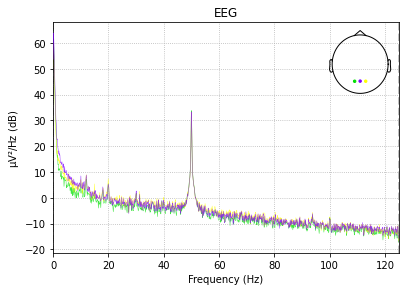

In [9]:
raw = helper.df_to_raw(df)

# 3. Preprocessing

## Notch Filter

Some artifacts are restricted to certain frequencies and can therefore be fixed by filtering. An artifact that typically affects only some frequencies is due to the power line.

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 125Hz (250Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 125 Hz.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Effective window size : 8.192 (s)


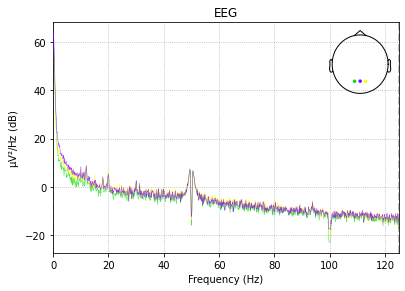

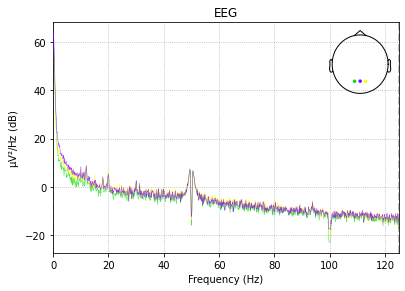

In [10]:
raw.notch_filter(np.arange(50, 125, 50), filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem
#observe that the 50Hz noise is now gone, yay!
raw.plot_psd()

## Band pass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 24 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 5.00, 24.00 Hz: -6.02, -6.02 dB

Effective window size : 8.192 (s)


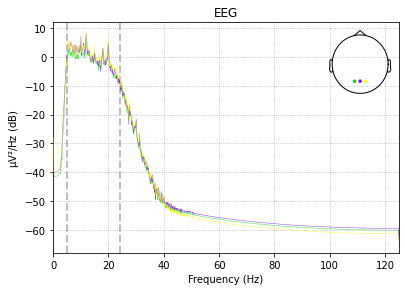

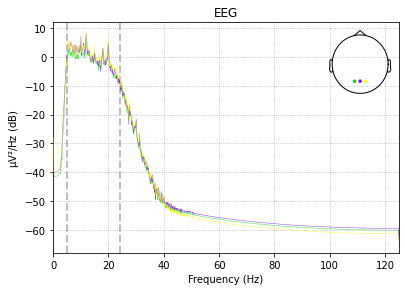

In [11]:
#Filter code looks like this
raw.filter(5,24, method='iir')

raw.plot_psd()

## Independent component analysis

SSVEP is not sensitive against eye artifacts

# 3. Epoching

In [12]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'6Hz': 1, '10Hz' : 2} #, '15Hz' : 3}
tmin=-0.5
tmax=2.5
epochs = helper.getEpochs(raw, event_id, tmin, tmax)

20 events found
Event IDs: [1 2]
sample drop %:  0.0


## Stimuli-Specific PSD

Effective window size : 4.112 (s)
Effective window size : 4.112 (s)


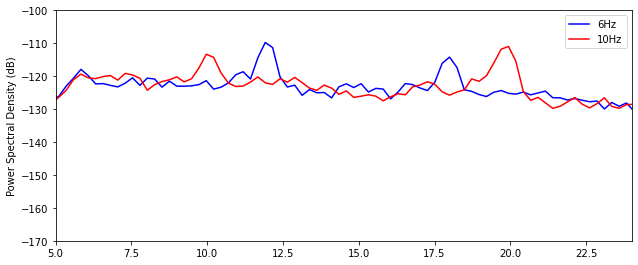

In [13]:
fig = plt.figure(figsize=(10, 4))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

psd1, freq1 = psd_welch(epochs['6Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['10Hz'], n_fft=1028, n_per_seg=256 * 3)
#psd3, freq3 = psd_welch(epochs['15Hz'], n_fft=1028, n_per_seg=256 * 3)

logpsd1 = 10 * np.log10(psd1)
logpsd2 = 10 * np.log10(psd2)
#logpsd3 = 10 * np.log10(psd3)

log_psd1_mean = logpsd1.mean(0)
log_psd1_std = logpsd1.mean(0)

log_psd2_mean = logpsd2.mean(0)
log_psd2_std = logpsd2.mean(0)

#log_psd3_mean = logpsd3.mean(0)
#log_psd3_std = logpsd3.mean(0)

axes.plot(freq1, log_psd1_mean[[0,2], :].mean(0), color='b', label='6Hz')
axes.plot(freq2, log_psd2_mean[[0,2], :].mean(0), color='r', label='10Hz')
#axes.plot(freq2, log_psd3_mean[[0,2], :].mean(0), color='g', label='15Hz')

axes.set_title('')
axes.set_ylabel('Power Spectral Density (dB)')
axes.set_xlim(5, 24)
axes.set_ylim(-170, -100)
axes.legend()

# Decoding

In [14]:
import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from mne import Epochs, find_events
from mne.decoding import CSP, Vectorizer, Scaler

from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances

from collections import OrderedDict
import helper as helper

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

epochs.pick_types(eeg=True)
X = epochs.get_data() #n_epochs * n_channel * n_time_samples  
y = epochs.events[:, -1]

cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2)

clfs = OrderedDict()

lda = LDA(shrinkage='auto', solver='eigen') #Regularized LDA
svc = OneVsRestClassifier(SVC())
lr = LogisticRegression(multi_class='multinomial')
knn = KNeighborsClassifier(n_neighbors=3) #you would want to optimize
nb = GaussianNB()
rf = RandomForestClassifier(n_estimators=50)
mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
ts = TSclassifier()    
# vec = Vectorizer()    
# scale = Scaler(epoch.info)  #by default, CSP already does this, but if you use Vectorizer, you hve to do it before Vectorizing
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)

# #clfs['Vectorizer + LDA'] = Pipeline([('Scaler', scale), ('Vectorizer', vec), ('Model', lda)])
clfs['CSP + LDA'] = Pipeline([('CSP', csp), ('lda', lda)])
clfs['CSP + SVC'] = Pipeline([('CSP', csp), ('svc', svc)])
clfs['CSP + LR'] = Pipeline([('CSP', csp), ('lr', lr)])
clfs['CSP + KNN'] = Pipeline([('CSP', csp), ('Model', knn)])
clfs['CSP + NB'] = Pipeline([('CSP', csp), ('nb', nb)])
clfs['CSP + RF'] = Pipeline([('CSP', csp), ('rf', rf)])
clfs['Cov + MDM'] = Pipeline([('Cov', Covariances('oas')), ('mdm', mdm)]) #oas is needed for non-PD matrix
clfs['Cov + TS'] = Pipeline([('Cov', Covariances('oas')), ('ts', ts)]) #oas is needed for non-PD matrix


auc = []
methods = []

for m in clfs:
    res = cross_val_score(clfs[m], X, y, cv=cv)
    auc.extend(res)
    methods.extend([m]*len(res))

    
results = pd.DataFrame(data=auc, columns=['Cross-Validated-Scores'])
results['Method'] = methods  


Computing rank from data with rank=None
    Using tolerance 4.2e-07 (2.2e-16 eps * 3 dim * 6.2e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.8e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 3 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated

/home/chaklam/bci_project/bci_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/chaklam/bci_project/bci_env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Done.
Computing rank from data with rank=None
    Using tolerance 4.2e-07 (2.2e-16 eps * 3 dim * 6.3e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 3 dim * 6.6e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4e-07 (2.2e-16 eps * 3 dim * 5.9e+08  max singular value)
    Estim

    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 3 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating

Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.2e-07 (2.2e-16 eps * 3 dim * 6.4e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolera

    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-07 (2.2e-16 eps * 3 dim * 6.7e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 3 dim * 6.6e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed 

Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-07 (2.2e-16 eps * 3 dim * 6.4e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-07 (2.2e-16 eps * 3 dim * 6.8e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-07 (2.2e-16 eps * 3 dim * 6.7e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolera

    Using tolerance 4.3e-07 (2.2e-16 eps * 3 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-07 (2.2e-16 eps * 3 dim * 6.8e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 3 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed 

    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-07 (2.2e-16 eps * 3 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOL

Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4e-07 (2.2e-16 eps * 3 dim * 6e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 3 dim * 6.6e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-07 (2.2e-16 eps * 3 dim * 7e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-07 (2.2e-16 eps * 3 dim * 6.

    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-07 (2.2e-16 eps * 3 dim * 6.7e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 3 dim * 6.6e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating

Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 3 dim * 6.6e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-07 (2.2e-16 eps * 3 dim * 7e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-07 (2.2e-16 eps * 3 dim * 6.5e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim 

    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-07 (2.2e-16 eps * 3 dim * 6.4e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.8e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating

Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.9e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-07 (2.2e-16 eps * 3 dim * 6.4e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-07 (2.2e-16 eps * 3 dim * 6.8e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolera

    Using tolerance 4e-07 (2.2e-16 eps * 3 dim * 6.1e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-07 (2.2e-16 eps * 3 dim * 6.7e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4e-07 (2.2e-16 eps * 3 dim * 6e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-07 (2.2e-16 eps * 3 dim * 6.6e+08  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3

     Cross-Validated-Scores     Method
0                      0.25  CSP + LDA
1                      0.75  CSP + LDA
2                      0.50  CSP + LDA
3                      0.50  CSP + LDA
4                      1.00  CSP + LDA
..                      ...        ...
235                    0.50   Cov + TS
236                    0.25   Cov + TS
237                    0.75   Cov + TS
238                    0.50   Cov + TS
239                    0.75   Cov + TS

[240 rows x 2 columns]


(0.2, 1.0)

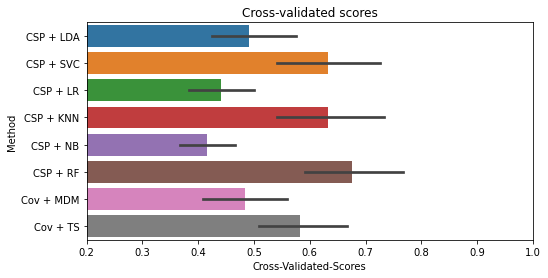

In [15]:
print(results)

figure = plt.figure(figsize=[8,4])
plt.title("Cross-validated scores")
sns.barplot(data=results, x='Cross-Validated-Scores', y='Method')
plt.xlim(0.2, 1)   

# Recurrent Network - LSTM

In [16]:
import lstmDecoding as lstm
lstm.decode(raw, event_id, tmin, tmax)

Using TensorFlow backend.


20 events found
Event IDs: [1 2]
sample drop %:  0.0
Epoch 1/5
16/16 [==============================] - 2s 148ms/step - loss: -7.6666 - accuracy: 0.5000
Epoch 2/5
16/16 [==============================] - 1s 56ms/step - loss: -7.6666 - accuracy: 0.5000
Epoch 3/5
16/16 [==============================] - 1s 36ms/step - loss: -7.6666 - accuracy: 0.5000
Epoch 4/5
16/16 [==============================] - 1s 36ms/step - loss: -7.6666 - accuracy: 0.5000
Epoch 5/5
4/4 [==============================] - 0s 68ms/step
Accuracy: 50.00%


# Temporal CNN

In [17]:
import tcnDecoding as tcn #custom
tcn.decode(raw, event_id, tmin, tmax)

20 events found
Event IDs: [1 2]
sample drop %:  0.0
751
4
Train on 12 samples, validate on 4 samples
Epoch 1/5
12/12 [==============================] - 4s 309ms/sample - loss: 24.4228 - accuracy: 0.0000e+00 - val_loss: 19.2812 - val_accuracy: 0.0000e+00
Epoch 2/5
12/12 [==============================] - 0s 21ms/sample - loss: 24.4228 - accuracy: 0.0000e+00 - val_loss: 19.2812 - val_accuracy: 0.0000e+00
Epoch 3/5
12/12 [==============================] - 0s 37ms/sample - loss: 24.4228 - accuracy: 0.0000e+00 - val_loss: 19.2812 - val_accuracy: 0.0000e+00
Epoch 4/5
12/12 [==============================] - 0s 18ms/sample - loss: 24.4228 - accuracy: 0.0000e+00 - val_loss: 19.2812 - val_accuracy: 0.0000e+00
Epoch 5/5
4/4 [==============================] - 0s 7ms/sample - loss: 23.1374 - accuracy: 0.0000e+00
Accuracy: 0.00%


# Spectral Decoding

In [18]:
import spectralDecoding as spec
spec.decode(raw, event_id, tmin, tmax)

20 events found
Event IDs: [1 2]
sample drop %:  0.0
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.6
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.6
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.4
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.6
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.8
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.4
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.4
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.6
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.6
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Accuracy score: 0.4
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)

# MNE-Features

In [19]:
from mne_features.feature_extraction import FeatureExtractor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import helper as helper

X = epochs.get_data()
y = epochs.events[:, -1]

###############################################################################
# Prepare for the classification task:

#for selected funcs params, see the api for alias
#read more here -> https://mne.tools/mne-features/api.html

#here is the list of features
features = (['app_entropy', 'decorr_time', 'energy_freq_bands', 
            'higuchi_fd', 'hjorth_complexity', 'hjorth_complexity_spect', 
            'hjorth_mobility', 'hjorth_mobility_spect', 'hurst_exp', 
            'katz_fd', 'kurtosis', 'line_length', 'mean', 'pow_freq_bands', 
            'ptp_amp', 'samp_entropy', 'skewness', 'spect_edge_freq', 
            'spect_entropy', 'spect_slope', 'std', 'svd_entropy', 
            'svd_fisher_info', 'teager_kaiser_energy', 'variance', 
            'wavelet_coef_energy', 'zero_crossings', 'max_cross_corr', 
            'nonlin_interdep', 'phase_lock_val', 'spect_corr', 'time_corr'])

#if you prefer to loop through all features

for feature in features:    
    pipe = Pipeline([('fe', FeatureExtractor(sfreq=raw.info['sfreq'],
                                         selected_funcs= [feature])),  #comment out if you want to try to see all features
                 ('scaler', StandardScaler()),
                 ('clf', LogisticRegression(random_state=None, solver='lbfgs'))])
    cv = StratifiedKFold(n_splits=5, random_state=None)
    scores = cross_val_score(pipe, X, y, cv=cv)
    print('Cross-validation accuracy score (with ' +  feature + ') = %1.3f '
      '(+/- %1.5f)' % (np.mean(scores), np.std(scores)))

Cross-validation accuracy score (with app_entropy) = 0.550 (+/- 0.10000)
Cross-validation accuracy score (with decorr_time) = 0.600 (+/- 0.33912)
Cross-validation accuracy score (with energy_freq_bands) = 0.950 (+/- 0.10000)
Cross-validation accuracy score (with higuchi_fd) = 0.850 (+/- 0.20000)
Cross-validation accuracy score (with hjorth_complexity) = 0.450 (+/- 0.24495)
Cross-validation accuracy score (with hjorth_complexity_spect) = 0.800 (+/- 0.10000)
Cross-validation accuracy score (with hjorth_mobility) = 0.650 (+/- 0.30000)
Cross-validation accuracy score (with hjorth_mobility_spect) = 0.650 (+/- 0.20000)
Cross-validation accuracy score (with hurst_exp) = 0.650 (+/- 0.25495)
Cross-validation accuracy score (with katz_fd) = 0.350 (+/- 0.30000)
Cross-validation accuracy score (with kurtosis) = 0.450 (+/- 0.18708)
Cross-validation accuracy score (with line_length) = 0.700 (+/- 0.24495)
Cross-validation accuracy score (with mean) = 0.550 (+/- 0.24495)
Cross-validation accuracy scor